## Imports

In [1]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import random
import numpy as np
from sklearn.cluster import KMeans
from sklearn import decomposition
from sklearn import preprocessing
from pathlib import Path
import scipy.io
import py_pcha
import time

import warnings
warnings.filterwarnings('ignore')

## Load dataset

In [2]:
path = Path().cwd()

data_path = path.parent / "Week_11" / "Data" / "zipdata.mat"
mat = scipy.io.loadmat(data_path)

traindata = mat['traindata']

y=traindata[:,0].T+1
X=traindata[:,1:].T
X=X-np.min(X)

p, n = np.shape(X)

print(f'number of observations: {n}, number of features: {p}')

number of observations: 7291, number of features: 256


## NMF functions

In [3]:
def NMFLS(X,noc,maxiter=50,W=None,H=None):
    # Non-negative matrix factorization based on Multiplicative Updates
    #
    # Minimize 0.5*||X-WH||_F^2 s.t. W>=0, H>=0
    #
    # Input
    #   X       I x J data matrix
    #   noc     number of components
    #   maxiter maximum number of iterations
    #
    # Output
    #   W           I x noc non-negative matrix
    #   H           noc x J non-negative matrix
    #   L           Least square error of fit, i.e. 0.5*||X-XSH||_F^2
    #   cpu_time    pr. iteration cost

    I,J = X.shape

    if W is None:
        W=np.random.rand(I,noc)
    if H is None:
        H=np.random.rand(noc,J)
        
    L=np.zeros(maxiter)
    cpu_time=np.zeros(maxiter)
    SST=np.sum(X*X)
    HHt=H @ H.T
    
    tol=1e-9*np.sqrt(SST/(I*J))
    eps = np.finfo(np.float32).eps
    
    for iter_ in range(maxiter):
        start_time = time.time()      
        
        #Update W
        XHt=X @ H.T    
        for k in range(10): # Take 10 steps to save computations
            W=np.where(W>tol, W, tol) * XHt / (W @ HHt+eps)

        #Update H
        WtX=W.T @ X
        WtW=W.T @ W
        for k in range(10): # Take 10 steps to save computations
            H=np.where(H>tol, H, tol) * WtX / (WtW @ H+eps);

        #Evaluate objective function
        HHt=H @ H.T
        L[iter_]=0.5*(SST+np.sum(WtW*HHt)-2*np.sum(WtX*H))
        
        cpu_time[iter_]=time.time() - start_time
        
        print('iter {} objective value {:f} pct. explained variance {:f}'.format(iter_,L[iter_],(1-L[iter_]/(0.5*SST))*100))
        
    return W, H, L, cpu_time

In [4]:
def NMFKL(X,noc,maxiter=50,W=None,H=None):
    # Non-negative matrix factorization based on Multiplicative Updates
    #
    # Minimize \sum_{i,j} (WH)_ij log(x_(ij)/(WH)_ij)+x_ij-(WH)_ij  s.t. W>=0, H>=0
    #
    # Input
    #   X    I x J data matrix
    #   noc  number of components
    #
    # Output
    #   W    I x noc non-negative matrix
    #   H    noc x J non-negative matrix
    #   L    Least square error of fit, i.e. 0.5*||X-XSH||_F^2

    I,J = X.shape

    if W is None:
        W=np.random.rand(I,noc)
    if H is None:
        H=np.random.rand(noc,J)
        
    L=np.zeros(maxiter)
    L_LS=np.zeros(maxiter)
    SST=np.sum(X*X)
    R=W @ H
    
    tol=1e-9*np.sqrt(SST/(I*J))
    eps = np.finfo(np.float32).eps
    
    for iter_ in range(maxiter):

        # Update W (add eps to all the denominators to avoid dividing by zero)    
        W = np.where(W>tol, W, tol) * ((X /(R+eps)) @ H.T @ np.diag(1 / (np.sum(H,axis=1)+eps)))


        # Update H (add eps to all the denominators to avoid dividing by zero)
        R=W @ H
        H = np.where(H>tol, H, tol) * (np.diag(1 /(np.sum(W, axis=0)+eps)) @ W.T @ (X /(R+eps)))        

        # Evaluate objective function
        R=W @ H
        L[iter_]=np.sum(X*np.log((X+eps)/(R+eps)))-np.sum(X)+np.sum(R)
        L_LS[iter_]=0.5*np.sum((R-X)**2) # Calculate LS error for comparison to KL
        
        print('iter {} objective value {:f} pct. explained variance {:f}'.format(iter_,L[iter_],(1-L_LS[iter_]/(0.5*SST))*100))
    
    return W, H, L, L_LS

## Perform NMF

In [5]:
Ndigit=250 #Limit the number of observation we use for speed purposes
n_components=25

W_LS, H_LS, L_LS, _ = NMFLS(X[:,0:Ndigit],n_components,maxiter=250)
W_KL, H_KL, L_KL, L_LSKL = NMFKL(X[:,0:Ndigit],n_components,maxiter=250,W=W_LS,H=H_LS)

iter 0 objective value 12810.055494 pct. explained variance 55.467227
iter 1 objective value 7527.393770 pct. explained variance 73.831830
iter 2 objective value 6085.234472 pct. explained variance 78.845340
iter 3 objective value 5563.645203 pct. explained variance 80.658589
iter 4 objective value 5322.832504 pct. explained variance 81.495748
iter 5 objective value 5183.234400 pct. explained variance 81.981046
iter 6 objective value 5092.715565 pct. explained variance 82.295725
iter 7 objective value 5030.497782 pct. explained variance 82.512018
iter 8 objective value 4984.188504 pct. explained variance 82.673008
iter 9 objective value 4946.761210 pct. explained variance 82.803120
iter 10 objective value 4916.353773 pct. explained variance 82.908828
iter 11 objective value 4890.341019 pct. explained variance 82.999258
iter 12 objective value 4867.748253 pct. explained variance 83.077800
iter 13 objective value 4848.640213 pct. explained variance 83.144227
iter 14 objective value 4831.

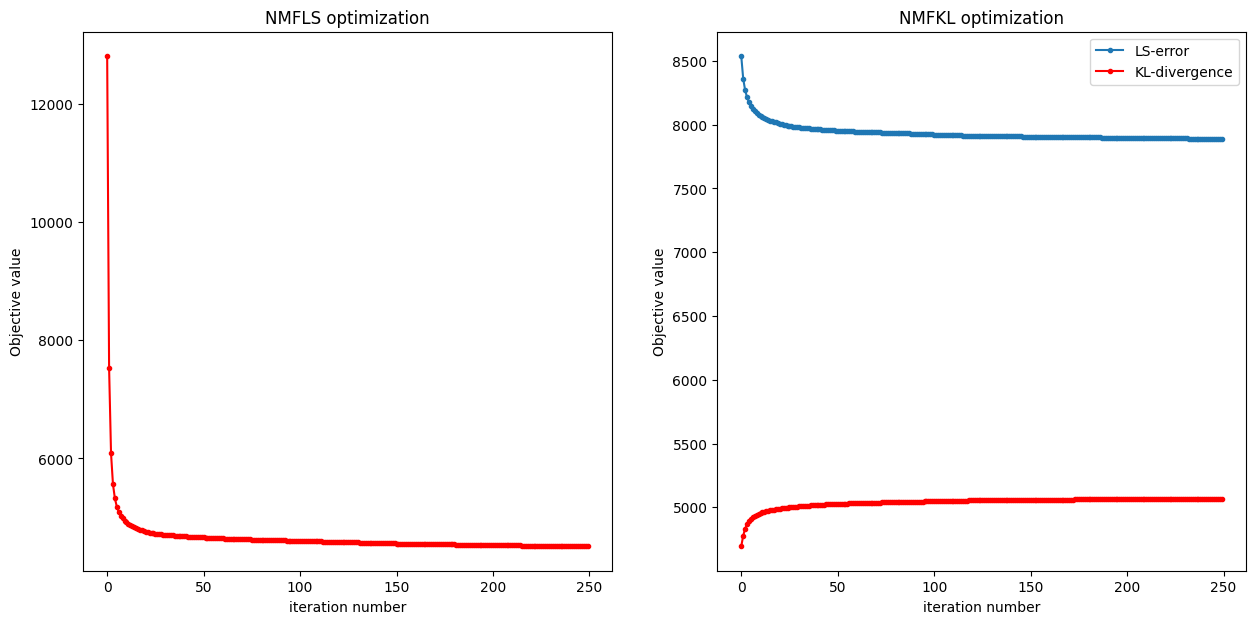

In [6]:
fig, ax = plt.subplots(1,2,figsize=(15,7))

_ = ax[0].plot(L_LS,'.-r')
ax[0].set_title('NMFLS optimization')
ax[0].set_ylabel('Objective value')
ax[0].set_xlabel('iteration number')

#Display KL error and corresponding LS error
_ = ax[1].plot(L_KL,'.-')
_ = ax[1].plot(L_LSKL,'.-r') # Corresponding LS error for each iteration of NMFKL
ax[1].set_title('NMFKL optimization')
ax[1].set_ylabel('Objective value')
ax[1].set_xlabel('iteration number')
ax[1].legend({'KL-divergence','LS-error'})

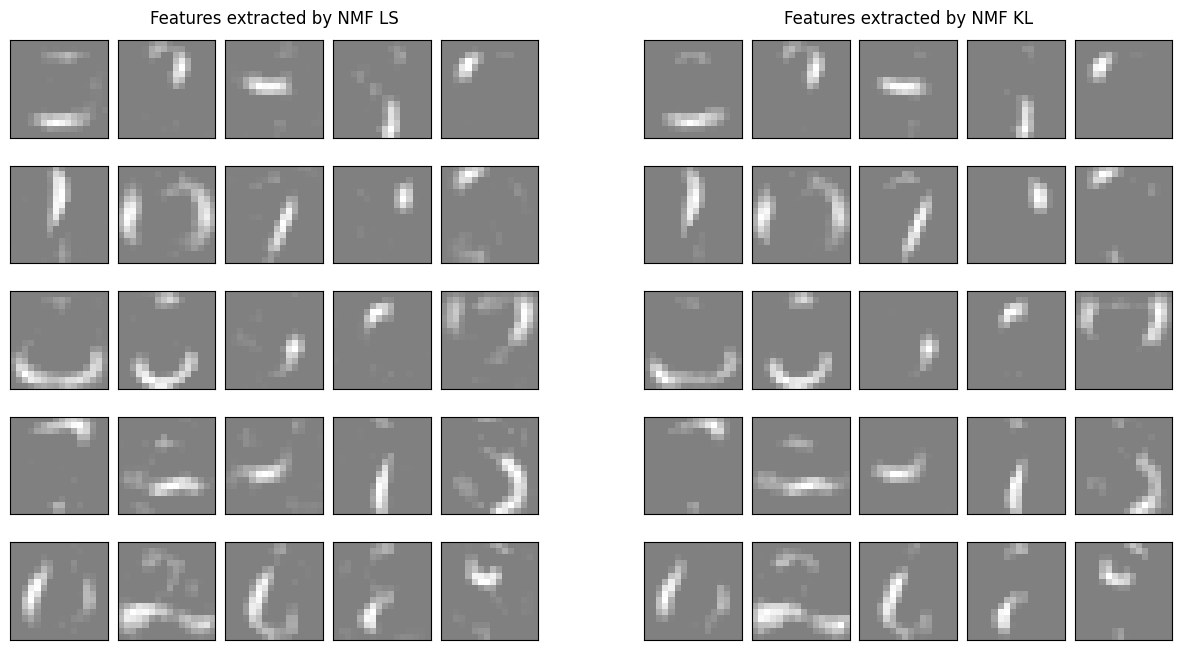

In [7]:
image_shape = (16, 16, n_components)
left = 0.0
right = 0.0
bottom = 0.99
top = 0.83
wspace = 0.0
hspace = 0.0
fig = plt.figure(figsize=(15, 8))
outer = gridspec.GridSpec(1, 2, wspace=0.2, hspace=0.2)

# Display the extracted features of NMFLS
ax = plt.Subplot(fig, outer[0])
ax.set_title('Features extracted by NMF LS')
ax.axis('off')
fig.add_subplot(ax)
    
inner = gridspec.GridSpecFromSubplotSpec(5, 5, subplot_spec=outer[0], wspace=0.1, hspace=0.1)
comps = np.reshape(W_LS,image_shape)
for i in range(n_components):
    comp = comps[:,:,i]
    ax = plt.Subplot(fig, inner[i])
    # normalize colormap
    vmax = max(comp.max(), -comp.min())
    ax.imshow(comp, cmap=plt.cm.gray, interpolation='nearest', vmin=-vmax, vmax=vmax)
    ax.set_xticks([])
    ax.set_yticks([])
    fig.add_subplot(ax)

# Display the extracted features of NMFKL
ax = plt.Subplot(fig, outer[1])
ax.set_title('Features extracted by NMF KL')
ax.axis('off')
fig.add_subplot(ax)
    
inner = gridspec.GridSpecFromSubplotSpec(5, 5, subplot_spec=outer[1], wspace=0.1, hspace=0.1)
comps = np.reshape(W_KL,image_shape)
for i in range(n_components):
    comp = comps[:,:,i]
    ax = plt.Subplot(fig, inner[i])
    # normalize colormap
    vmax = max(comp.max(), -comp.min())
    ax.imshow(comp, cmap=plt.cm.gray, interpolation='nearest', vmin=-vmax, vmax=vmax)
    ax.set_xticks([])
    ax.set_yticks([])
    fig.add_subplot(ax)